In [ ]:
!pip install torch

!python -m pip install -U pip

!python -m pip install -U scikit-image



In [ ]:
import torch
from tqdm import tqdm_notebook
import torchvision
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.metrics import accuracy_score,precision_score,recall_score
import torchvision.transforms as transforms
from google.colab import drive
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.optim as optim


En este script realizaran distintas actividades de Computer Vision, primero se intentara clasificar un dataset con redes neuronales normales, luego se aplicaran CNN, diversas tecnicas de procesamiento de imagenes (Filtros,BatchNormalization,Resize) y se compararan los resultados.


Estas pruebas se realizaran tanto en el dataset MNIST como en el CIFAR-10, asi podremos ver la diferencia entre imagenes blanco y negro e imagenes a color.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#basepath = "/content/drive"
#fullpath_mnsit = "{}/My Drive/UPC/mnist-in-csv/".format(basepath)
#fullpath_cifar = "{}/My Drive/UPC/cifar10/".format(basepath)

#drive.mount(basepath)

## Carga de Datos MNIST

In [ ]:
resultados_eval = []

In [ ]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

In [ ]:
train_data.data[0]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

In [ ]:
train_data.data.shape

torch.Size([60000, 28, 28])

In [ ]:
trainset_nn = train_data.data/255.

trainset_nn = trainset_nn.reshape(60000,28*28)

testset_nn = test_data.data/255.


testset_nn = testset_nn.reshape(10000,28*28)

print(trainset_nn.shape)

print(testset_nn.shape)



torch.Size([60000, 784])
torch.Size([10000, 784])


In [ ]:
targets_train_nn = train_data.targets.long()
targets_test_nn = test_data.targets.long()

Seleccionamos una muestra de 25 imagenes, para realizar un grafico.

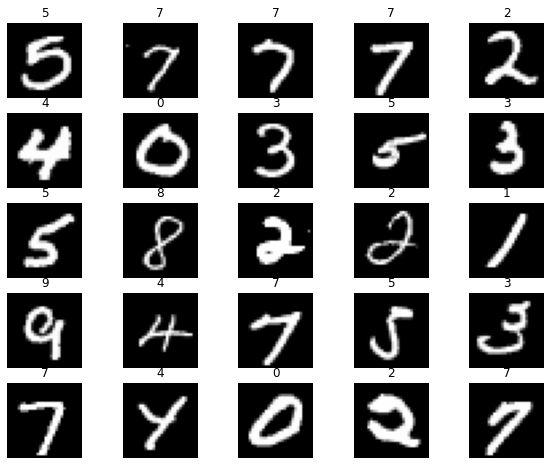

In [ ]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [ ]:


X_train_tensor = trainset_nn.float()
y_train_tensor = targets_train_nn
X_test_tensor = testset_nn.float()
y_test_tensor = targets_test_nn

Como es una red neuronal convencional el input sera un vector de 784 elementos.

In [ ]:
X_train_tensor.shape

torch.Size([60000, 784])

X_train tiene 60000 vectores de 784 elementos.Normalizamos los features.

# Red Neuronal Convencional MNIST



* input_size : Numero de elementos en el vector (784)
* output_size : etiquetas de salida (10)

* hidden_size_1 : 32 
* hidden_size_2 : 64

In [ ]:
input_size = X_train_tensor[0].shape[0]
output_size = len(list(set(targets_test_nn.detach().cpu().numpy())))

hidden_size_1 = 32 
hidden_size_2 = 64

In [ ]:
input_size

784

Construimos nuestra red neuronal. 

In [ ]:
class ImgClf(nn.Module):

    def __init__(self):


        super(ImgClf,self).__init__()

        self.fc1 = nn.Linear(input_size,hidden_size_1)
        self.fc2 = nn.Linear(hidden_size_1,hidden_size_2)
        self.fc3 = nn.Linear(hidden_size_2,output_size)


    def forward(self,x):

        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))

        x = self.fc3(x)

        return torch.log_softmax(x,dim = -1)

In [ ]:
model = ImgClf()

In [ ]:
model.to(device)

ImgClf(
  (fc1): Linear(in_features=784, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

## Entrenamos el modelo

In [ ]:


optimizer = optim.Adam(model.parameters())

loss_fn = nn.NLLLoss()

In [ ]:
epochs = 500

for epoch in range(1,epochs+1):

    optimizer.zero_grad()

    y_pred = model(X_train_tensor.to(device))

    loss = loss_fn(y_pred.to(device),y_train_tensor.to(device))

    loss.backward()

    optimizer.step()

    if epoch % 10 == 0:

        print(f'Epoch - {epoch}, loss {loss.item()} ')

Epoch - 10, loss 2.284897565841675 
Epoch - 20, loss 2.25913143157959 
Epoch - 30, loss 2.2180042266845703 
Epoch - 40, loss 2.1599793434143066 
Epoch - 50, loss 2.0820260047912598 
Epoch - 60, loss 1.9846323728561401 
Epoch - 70, loss 1.8708159923553467 
Epoch - 80, loss 1.7465529441833496 
Epoch - 90, loss 1.6193567514419556 
Epoch - 100, loss 1.4960824251174927 
Epoch - 110, loss 1.3814609050750732 
Epoch - 120, loss 1.2779958248138428 
Epoch - 130, loss 1.1862934827804565 
Epoch - 140, loss 1.105573296546936 
Epoch - 150, loss 1.0344144105911255 
Epoch - 160, loss 0.9713084101676941 
Epoch - 170, loss 0.9148560762405396 
Epoch - 180, loss 0.8638082146644592 
Epoch - 190, loss 0.8170749545097351 
Epoch - 200, loss 0.7737407684326172 
Epoch - 210, loss 0.7331641912460327 
Epoch - 220, loss 0.6950510144233704 
Epoch - 230, loss 0.6593180298805237 
Epoch - 240, loss 0.6259368658065796 
Epoch - 250, loss 0.5948726534843445 
Epoch - 260, loss 0.5660713911056519 
Epoch - 270, loss 0.53945

## Evaluamos el Modelo

In [ ]:
with torch.no_grad():

    correct = 0
    total = 0

    outputs = model(X_test_tensor.to(device))
    _,predicted = torch.max(outputs.data,1)

    mnist_test_tg = targets_test_nn.detach().cpu().numpy()

    acc = accuracy_score(predicted.detach().cpu().numpy(),mnist_test_tg)
    recall = recall_score(predicted.detach().cpu().numpy(),mnist_test_tg,average='weighted') 
    precision = precision_score(predicted.detach().cpu().numpy(),mnist_test_tg,average='weighted')

    print('acc',acc)
    print('precison', precision)
    print('recall', recall)

    resultados_eval.append([acc,precision,recall])

acc 0.9273
precison 0.9278651022564472
recall 0.9273


# Red Neuronal Convolucional MNIST

In [ ]:

train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

In [ ]:
from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
}
loaders

{'test': <torch.utils.data.dataloader.DataLoader at 0x7f1883c80e50>,
 'train': <torch.utils.data.dataloader.DataLoader at 0x7f18837d9c50>}

* Input_size : 1



* Output_size2 : etiquetas de salida (10)

* Hidden_size_1 : 16 

* Hidden_size_2 : 32

* K_conv_size : 5



In [ ]:
Input_size = 1


Output_size2 = len(list(set(targets_test_nn.detach().cpu().numpy())))

Hidden_size_1 = 16 

Hidden_size_2 = 32

K_conv_size = 5


In [ ]:
class CNN1(nn.Module):

    def __init__(self):
        
        super(CNN1, self).__init__()
        
        self.conv1 = nn.Sequential(         
                nn.Conv2d(
                in_channels=1,              
                out_channels=Hidden_size_1,            
                kernel_size=K_conv_size,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(Hidden_size_1, Hidden_size_2, K_conv_size, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        
        self.out = nn.Linear(Hidden_size_2 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output

In [ ]:
model_cnn = CNN1()

In [ ]:
model_cnn.to(device)

CNN1(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)

In [ ]:
optimizer_cnn = torch.optim.Adam(model_cnn.parameters(),lr = 0.01)

criterion = nn.CrossEntropyLoss()  

train_loader = torch.utils.data.DataLoader(dataset=loaders['train'], batch_size=32, shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=loaders['test'], batch_size=32, shuffle=True)

In [ ]:
from torch.autograd import Variable
num_epochs = 10
#def train(num_epochs, cnn, loaders):
    
model_cnn.train()
    
# Train the model
total_step = len(loaders['train'])
    
for epoch in range(num_epochs):

    for i, (images, labels) in enumerate(loaders['train']):
        
        
        images = Variable(images).to(device)   
        labels = labels.to(device)  
        output = model_cnn(images)
        loss = criterion(output, labels)
        
        
        optimizer_cnn.zero_grad()           
        
        loss.backward()    
                     
        optimizer_cnn.step()                
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                    .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
        


Epoch [1/10], Step [100/600], Loss: 0.1906
Epoch [1/10], Step [200/600], Loss: 0.0768
Epoch [1/10], Step [300/600], Loss: 0.0320
Epoch [1/10], Step [400/600], Loss: 0.0509
Epoch [1/10], Step [500/600], Loss: 0.0986
Epoch [1/10], Step [600/600], Loss: 0.0713
Epoch [2/10], Step [100/600], Loss: 0.0324
Epoch [2/10], Step [200/600], Loss: 0.1287
Epoch [2/10], Step [300/600], Loss: 0.0477
Epoch [2/10], Step [400/600], Loss: 0.0778
Epoch [2/10], Step [500/600], Loss: 0.0183
Epoch [2/10], Step [600/600], Loss: 0.1393
Epoch [3/10], Step [100/600], Loss: 0.0553
Epoch [3/10], Step [200/600], Loss: 0.0466
Epoch [3/10], Step [300/600], Loss: 0.0121
Epoch [3/10], Step [400/600], Loss: 0.0116
Epoch [3/10], Step [500/600], Loss: 0.0207
Epoch [3/10], Step [600/600], Loss: 0.0217
Epoch [4/10], Step [100/600], Loss: 0.0857
Epoch [4/10], Step [200/600], Loss: 0.0514
Epoch [4/10], Step [300/600], Loss: 0.0013
Epoch [4/10], Step [400/600], Loss: 0.1214
Epoch [4/10], Step [500/600], Loss: 0.0784
Epoch [4/10

In [ ]:

model_cnn.eval()

with torch.no_grad():
      
      correct = 0
      
      total = 0
      
      for images, labels in loaders['test']:
      
          test_output = model_cnn(images.to(device))
      
          pred_y = torch.max(test_output, 1)[1]#.data.squeeze()
      
         
          acc = accuracy_score(pred_y.detach().cpu().numpy(),labels.detach().cpu().numpy())
          recall = recall_score(pred_y.detach().cpu().numpy(),labels.detach().cpu().numpy(),average='weighted') 
          precision = precision_score(pred_y.detach().cpu().numpy(),labels.detach().cpu().numpy(),average='weighted')

          #print('acc',acc)
          #print('precison', precision)
          #print('recall', recall)

          acc = np.mean(np.array(acc))
          recall = np.mean(np.array(recall))
          precision = np.mean(np.array(precision))

resultados_eval.append([acc,precision,recall])


In [ ]:
resultados_eval = pd.DataFrame(resultados_eval,columns = ['acc','precision','recall'],index = ['NN','CNN'])

In [ ]:
resultados_eval

,acc,precision,recall
NN,0.9273,0.927865,0.9273
CNN,0.9900,0.991111,0.9900


# Cifar - 10

In [ ]:
import pickle

In [ ]:
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz -P datasets
!tar xf datasets/cifar-10-python.tar.gz -C datasets

--2021-11-14 22:53:14--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘datasets/cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  17.0MB/s    in 11s     

2021-11-14 22:53:26 (15.1 MB/s) - ‘datasets/cifar-10-python.tar.gz’ saved [170498071/170498071]



In [ ]:
transformer =  transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor()])

In [ ]:
dataset_cifar = torchvision.datasets.CIFAR10(root = './image-classification-pytorch/datasets/cifar10/train',download=True,transform=transformer)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./image-classification-pytorch/datasets/cifar10/train/cifar-10-python.tar.gz to ./image-classification-pytorch/datasets/cifar10/train


In [ ]:
dataset_cifar

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./image-classification-pytorch/datasets/cifar10/train
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

Aca usaremos los elementos Dataset y Dataloader de pytorch, estos nos permiten manejar grandes cantidades de datos de forma mas eficiente.

In [ ]:
dataloader = torch.utils.data.DataLoader(dataset_cifar,
                                        batch_size = 16,
                                        shuffle = True,
                                        num_workers = 2)

Seleccionamos algunas imagenes

In [ ]:
images_batch,label_batch = iter(dataloader).next()
images_batch.shape

torch.Size([16, 3, 256, 256])

Se puede ver que las 16 imagenes (tamaño de batch) poseen 3 canales (RGB) y son de 256*256 pixeles

In [ ]:
img =  torchvision.utils.make_grid(images_batch)
img.shape

torch.Size([3, 518, 2066])

Cambiamos la forma del batch para que se pueda graficar.

In [ ]:
img = np.transpose(img,(1,2,0))
img.shape

torch.Size([518, 2066, 3])

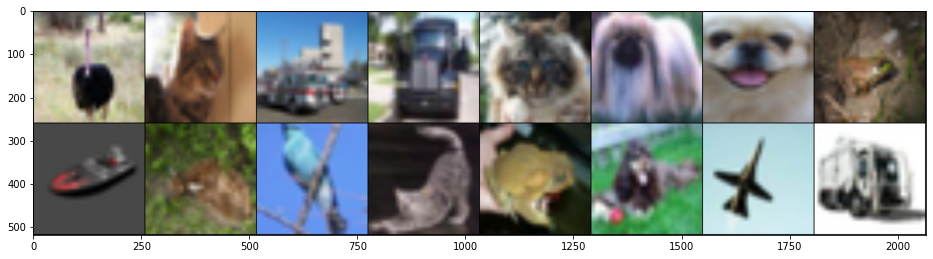

In [ ]:
plt.figure(figsize=(16,12))

plt.imshow(img)

Calculamos la media y la desviación estandar para realizar batch normalization, esto nos permite estandarizan el input entre capas.

In [ ]:
pop_mean = []
pop_std = []

for i,data in enumerate(dataloader, 0):

    numpy_image = data[0].numpy()

    batch_mean =  np.mean(numpy_image, axis = (0,2,3))

    batch_std = np.std(numpy_image, axis = (0,2,3))

    pop_mean.append(batch_mean)
    pop_std.append(batch_std)

pop_mean = np.array(pop_mean)
pop_std = np.array(pop_std)

pop_mean = pop_mean.mean(axis = 0)
pop_std = pop_std.mean(axis = 0)

Tando pop_mean como pop_std tienen tres elementos por cada canal.

Iniciamos nuestro tranformador, este elemento nos permite realizar tareas de porcesamiento a nuestros datos.

In [ ]:
transformer_train = transforms.Compose([
              transforms.Resize(32),
              transforms.RandomHorizontalFlip(),
              transforms.ToTensor(),
              transforms.Normalize(pop_mean,pop_std)
])

transformer_test = transforms.Compose([
              transforms.Resize(32),
              
              transforms.ToTensor(),
              transforms.Normalize(pop_mean,pop_std)
])

In [ ]:
trainset = torchvision.datasets.CIFAR10(root = './image-classification-pytorch/datasets/cifar10/train',download=True,train = True,transform = transformer_train)
testset = torchvision.datasets.CIFAR10(root = './image-classification-pytorch/datasets/cifar10/train',download=True,train = False,transform = transformer_train)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
trainset.data.shape

(50000, 32, 32, 3)

In [ ]:
trainset_nn = trainset.data/255.
trainset_nn = trainset_nn.reshape(-1,32*32*3)

testset_nn = testset.data/255.
testset_nn = testset_nn.reshape(-1,32*32*3)



trainset_nn = torch.tensor(trainset_nn).float().to(device)

testset_nn = torch.tensor(testset_nn).float().to(device)

In [ ]:
target_tr_nn = torch.tensor(trainset.targets)
target_ts_nn = torch.tensor(testset.targets)

In [ ]:

trainset_nn = trainset_nn.to(device)
testset_nn = testset_nn.to(device)

# Conventional Network

In [ ]:
input_size = trainset_nn[0].shape[0]
output_size = len(list(set(trainset.targets)))

hidden_size_1 = 64 
hidden_size_2 = 128
hidden_size_3 = 256
hidden_size_4 = 512

In [ ]:
output_size

10

In [ ]:
class ImgClf_CIFAR(nn.Module):

    def __init__(self):


        super(ImgClf_CIFAR,self).__init__()

        self.fc1 = nn.Linear(input_size,hidden_size_1)
        self.fc2 = nn.Linear(hidden_size_1,hidden_size_2)
        self.fc3 = nn.Linear(hidden_size_2,hidden_size_3)
        self.fc4 = nn.Linear(hidden_size_3,hidden_size_4)
        self.fc5 = nn.Linear(hidden_size_4,output_size)


    def forward(self,x):

        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))

        x = self.fc5(x)

        return torch.log_softmax(x,dim = -1)

In [ ]:

model_nn_cifar = ImgClf_CIFAR()

In [ ]:
model_nn_cifar.to(device)

ImgClf_CIFAR(
  (fc1): Linear(in_features=3072, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=512, bias=True)
  (fc5): Linear(in_features=512, out_features=10, bias=True)
)

In [ ]:
import torch.optim as optim

optimizer_cifar = optim.Adam(model_nn_cifar.parameters(),lr = 0.001)

loss_fn = nn.NLLLoss()

In [ ]:
epochs = 1500

for epoch in range(1,epochs+1):

    optimizer_cifar.zero_grad()

    y_pred = model_nn_cifar(torch.tensor(trainset_nn).float().to(device))

    loss = loss_fn(y_pred,target_tr_nn.to(device))

    loss.backward()

    optimizer_cifar.step()

    if epoch % 10 == 0:

        print(f'Epoch - {epoch}, loss {loss.item()} ')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Epoch - 10, loss 2.30837345123291 
Epoch - 20, loss 2.3014228343963623 
Epoch - 30, loss 2.288689613342285 
Epoch - 40, loss 2.2091307640075684 
Epoch - 50, loss 2.0748064517974854 
Epoch - 60, loss 2.0573277473449707 
Epoch - 70, loss 2.0485870838165283 
Epoch - 80, loss 2.0384607315063477 
Epoch - 90, loss 2.026235818862915 
Epoch - 100, loss 2.0129311084747314 
Epoch - 110, loss 1.9993222951889038 
Epoch - 120, loss 1.9866673946380615 
Epoch - 130, loss 1.9678703546524048 
Epoch - 140, loss 1.9488511085510254 
Epoch - 150, loss 1.9145431518554688 
Epoch - 160, loss 1.886749267578125 
Epoch - 170, loss 1.8696953058242798 
Epoch - 180, loss 1.8605101108551025 
Epoch - 190, loss 1.8500975370407104 
Epoch - 200, loss 1.839982509613037 
Epoch - 210, loss 1.8391422033309937 
Epoch - 220, loss 1.825350046157837 
Epoch - 230, loss 1.813101053237915 
Epoch - 240, loss 1.8051708936691284 
Epoch - 250, loss 1.800203561782837 
Epoch - 260, loss 1.787224531173706 
Epoch - 270, loss 1.77677333354

In [ ]:
resultados_eval_cifar = []

In [ ]:
model_nn_cifar.eval()

with torch.no_grad():
      
      correct = 0
      
      total = 0

      labels = target_ts_nn
      
      #for images in testset_nn:
      
      test_output = model_nn_cifar(testset_nn)
  
      pred_y  = torch.max(test_output, 1)[1].data.squeeze()
  
      
      acc = accuracy_score(pred_y.detach().cpu().numpy(),labels.detach().cpu().numpy())
      recall = recall_score(pred_y.detach().cpu().numpy(),labels.detach().cpu().numpy(),average='weighted') 
      precision = precision_score(pred_y.detach().cpu().numpy(),labels.detach().cpu().numpy(),average='weighted')

      #print('acc',acc)
      #print('precison', precision)
      #print('recall', recall)

      acc = np.mean(np.array(acc))
      recall = np.mean(np.array(recall))
      precision = np.mean(np.array(precision))

resultados_eval_cifar.append([acc,precision,recall])

In [ ]:
resultados_eval_cifar

[[0.4243, 0.46241680000000007, 0.4243]]

Convolutional Network CIFAR

In [ ]:
trainloader_cifar = torch.utils.data.DataLoader(trainset,batch_size = 16,shuffle = True,num_workers = 2)
testloader_cifar = torch.utils.data.DataLoader(testset,batch_size = 16,shuffle = True ,num_workers = 2)

In [ ]:
input_size = 3
output_size = 10

hidden_size_1 = 16
hidden_size_2 = 32

out_size_1 = 400
out_size_2 = 10

K_conv_size = 5


In [ ]:
class CNN_CIFAR(nn.Module):

  def __init__(self):
    super(CNN_CIFAR,self).__init__()


    self.layer1 = nn.Sequential(
        nn.Conv2d(input_size,hidden_size_1,K_conv_size),
        nn.BatchNorm2d(hidden_size_1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )

    self.layer2 = nn.Sequential(
        nn.Conv2d(hidden_size_1,hidden_size_2,K_conv_size),
        nn.BatchNorm2d(hidden_size_2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )

    self.layer3 = nn.Sequential(
        nn.Linear(hidden_size_2 * K_conv_size*K_conv_size,out_size_1),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(out_size_1,out_size_2)

    )    


  def forward(self,x):

    out = self.layer1(x)
    out = self.layer2(out)

    out = out.reshape(out.size(0),-1)

    out = self.layer3(out)

    return F.log_softmax(out,dim=-1)


In [ ]:
model_cnn_cifar = CNN_CIFAR()
model_cnn_cifar.to(device)

CNN_CIFAR(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Linear(in_features=800, out_features=400, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=400, out_features=10, bias=True)
  )
)

In [ ]:
optimizer_cnn = torch.optim.Adam(model_cnn_cifar.parameters(),lr = 0.001)

criterion = nn.NLLLoss()  


In [ ]:

num_epochs = 10

model_cnn_cifar.train()
    

total_step = len(trainloader_cifar)
    
for epoch in range(num_epochs):

    for i, (images, labels) in enumerate(trainloader_cifar):
        
        images, labels = images.to(device), labels.to(device) 
        output = model_cnn_cifar(images)               
        loss = criterion(output, labels)
        
        
        optimizer_cnn.zero_grad()           
        
        loss.backward()    
                    
        optimizer_cnn.step()                
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                    .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))

Epoch [1/10], Step [100/3125], Loss: 1.9015
Epoch [1/10], Step [200/3125], Loss: 1.9199
Epoch [1/10], Step [300/3125], Loss: 1.7374
Epoch [1/10], Step [400/3125], Loss: 1.6084
Epoch [1/10], Step [500/3125], Loss: 1.1978
Epoch [1/10], Step [600/3125], Loss: 1.4928
Epoch [1/10], Step [700/3125], Loss: 1.1065
Epoch [1/10], Step [800/3125], Loss: 1.4944
Epoch [1/10], Step [900/3125], Loss: 1.5002
Epoch [1/10], Step [1000/3125], Loss: 1.6518
Epoch [1/10], Step [1100/3125], Loss: 1.0316
Epoch [1/10], Step [1200/3125], Loss: 1.6580
Epoch [1/10], Step [1300/3125], Loss: 1.4864
Epoch [1/10], Step [1400/3125], Loss: 1.5708
Epoch [1/10], Step [1500/3125], Loss: 1.2627
Epoch [1/10], Step [1600/3125], Loss: 1.4566
Epoch [1/10], Step [1700/3125], Loss: 1.0571
Epoch [1/10], Step [1800/3125], Loss: 1.5074
Epoch [1/10], Step [1900/3125], Loss: 1.1733
Epoch [1/10], Step [2000/3125], Loss: 1.2425
Epoch [1/10], Step [2100/3125], Loss: 1.3335
Epoch [1/10], Step [2200/3125], Loss: 1.1665
Epoch [1/10], Step 

In [ ]:

model_cnn_cifar.eval()

with torch.no_grad():
      
      correct = 0
      
      total = 0
      
      for images, labels in testloader_cifar:#loaders['test']:
      
          test_output = model_cnn_cifar(images.to(device))
      
          pred_y = torch.max(test_output, 1)[1].data.squeeze()
      
         
          acc = accuracy_score(pred_y.detach().cpu().numpy(),labels.detach().cpu().numpy())
          recall = recall_score(pred_y.detach().cpu().numpy(),labels.detach().cpu().numpy(),average='weighted') 
          precision = precision_score(pred_y.detach().cpu().numpy(),labels.detach().cpu().numpy(),average='weighted')

          #print('acc',acc)
          #print('precison', precision)
          #print('recall', recall)

          acc = np.mean(np.array(acc))
          recall = np.mean(np.array(recall))
          precision = np.mean(np.array(precision))

resultados_eval_cifar.append([acc,precision,recall])

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
resultados_eval_cifar

[[0.4243, 0.46241680000000007, 0.4243], [0.6875, 0.71875, 0.6875]]

In [ ]:
resultados_eval = pd.DataFrame(resultados_eval_cifar,columns = ['acc','precision','recall'],index = ['NN','CNN'])

In [ ]:
resultados_eval

,acc,precision,recall
NN,0.4243,0.462417,0.4243
CNN,0.6875,0.718750,0.6875


Se puede ver como el modleo de CNN es superior tanto en MNIST como en CIFAR, se entrena con una menor cantidad de epochs y se optinen un mejor resultado.

En CIFAR se puede mejorar añadiendo mas capas y modificando algunos hiperparametros, en este dataset se ve como una red neuronal comun queda muy obsoleta en este tipo de aplicaciones.